# Report Joint Calling v1.0
## Input prameters

In [3]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.2f}'.format(x)
pd.set_option('display.max_colwidth', None)
configFile='jc_report.config'
parser = ConfigParser()
parser.read(configFile)

h5_statistics = parser.get('JCReport', 'h5_statistics', fallback='jc_statistics.h5')
annotation_names = parser.get('JCReport', 'annotation_names', fallback='jc_statistics.h5').split(',')
prmNames=['run_id','pipeline_version',
          'annotation_names', 'h5_statistics','allele_freq_known_snps','allele_freq_novel_snps',
          'allele_freq_known_indels','allele_freq_novel_indels'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('JCReport', name, fallback='NA')
    
h5outfile = parser.get('JCReport', 'h5_output', fallback='jc_report.h5')
allele_freq_known_snps = parser.get('JCReport', 'allele_freq_known_snps', fallback='allele_freq_known_snps.txt')
allele_freq_novel_snps = parser.get('JCReport', 'allele_freq_novel_snps', fallback='allele_freq_novel_snps.txt')
allele_freq_known_indels = parser.get('JCReport', 'allele_freq_known_indels', fallback='allele_freq_known_indels.txt')
allele_freq_novel_indels = parser.get('JCReport', 'allele_freq_novel_indels', fallback='allele_freq_novel_indels.txt')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,annot_file
pipeline_version,1.0.0
annotation_names,"exome,wgs,extended_exome,high_conf"
h5_statistics,annot_file.h5
allele_freq_known_snps,NA
allele_freq_novel_snps,NA
allele_freq_known_indels,annot_file_allele_freq_k_indels.txt
allele_freq_novel_indels,annot_file_allele_freq_n_indels.txt


## Variants Statistics

In [4]:
import pandas as pd
def metric_table_annotation(h5_path, annotation_name='none'):

    JexlExpression = annotation_name
    meteric_table = pd.DataFrame(index=['novel','known','all'],columns=['nSNPs','nIndels','TiTv ratio','insertion-deletion ratio',
                                                                'dbsnp snps ratio','dbsnp indels ratio',
                                                                'biallelic snp ratio','biallelic indels ratio',
                                                               'n_singleton_SNPs','n_singleton_indels'])
        
    indelSammary = pd.read_hdf(h5_path,'/eval_IndelSummary')
    indelSammary[['insertion_to_deletion_ratio',
        'n_singleton_SNPs',
        'n_singleton_indels']] = indelSammary[['insertion_to_deletion_ratio',
                                        'n_singleton_SNPs',
                                        'n_singleton_indels']].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    meteric_table.loc['known','insertion-deletion ratio']=float(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='known'),'insertion_to_deletion_ratio'].values[0])
    meteric_table.loc['novel','insertion-deletion ratio']=float(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='novel'),'insertion_to_deletion_ratio'].values[0])
    meteric_table.loc['all','insertion-deletion ratio']=float(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='all'),'insertion_to_deletion_ratio'].values[0])
    #nSingleton
    meteric_table.loc['known','n_singleton_SNPs']=int(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='known'),'n_singleton_SNPs'].values[0])
    meteric_table.loc['novel','n_singleton_SNPs']=int(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='novel'),'n_singleton_SNPs'].values[0])
    meteric_table.loc['all','n_singleton_SNPs']=int(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='all'),'n_singleton_SNPs'].values[0])
    meteric_table.loc['known','n_singleton_indels']=int(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='known'),'n_singleton_indels'].values[0])
    meteric_table.loc['novel','n_singleton_indels']=int(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='novel'),'n_singleton_indels'].values[0])
    meteric_table.loc['all','n_singleton_indels']=int(indelSammary.loc[(indelSammary['JexlExpression']==JexlExpression) & (indelSammary['Novelty']=='all'),'n_singleton_indels'].values[0])
    #dnsnp_ratio
    variantSummary = pd.read_hdf(h5_path,'/eval_VariantSummary')
    variantSummary[[
        'nSNPs',
        'nIndels',
        'TiTvRatio']] = variantSummary[['nSNPs',
                                        'nIndels',
                                        'TiTvRatio']].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    def get_ratio(a,b):
        if b==0: return np.nan
        return a/b
    meteric_table.loc['all','dbsnp snps ratio']=get_ratio(int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='known'),'nSNPs'].values[0]),
                                                          int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='all'),'nSNPs'].values[0]))
    meteric_table.loc['all','dbsnp indels ratio']=get_ratio(int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='known'),'nIndels'].values[0]),
                                                          int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='all'),'nIndels'].values[0]))
    # number of snps and indels
    meteric_table.loc['known','nSNPs']=int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='known'),'nSNPs'].values[0])
    meteric_table.loc['novel','nSNPs']=int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='novel'),'nSNPs'].values[0])
    meteric_table.loc['all','nSNPs']=int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='all'),'nSNPs'].values[0])
    meteric_table.loc['known','nIndels']=int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='known'),'nIndels'].values[0])
    meteric_table.loc['novel','nIndels']=int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='novel'),'nIndels'].values[0])
    meteric_table.loc['all','nIndels']=int(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='all'),'nIndels'].values[0])
    #TiTvRatio
    meteric_table.loc['novel','TiTv ratio']=float(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='novel'),'TiTvRatio'].values[0])
    meteric_table.loc['known','TiTv ratio']=float(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='known'),'TiTvRatio'].values[0])
    meteric_table.loc['all','TiTv ratio']=float(variantSummary.loc[(variantSummary['JexlExpression']==JexlExpression) & (variantSummary['Novelty']=='all'),'TiTvRatio'].values[0])
    #MultiSnpRatio
    multiallelicSummary = pd.read_hdf(h5_path,'/eval_MultiallelicSummary')
    meteric_table.loc['known','biallelic snp ratio']=float(multiallelicSummary.loc[(multiallelicSummary['JexlExpression']==JexlExpression) & (multiallelicSummary['Novelty']=='known'),'variantMultiSnpRatio'].values[0])
    meteric_table.loc['known','biallelic indels ratio']=float(multiallelicSummary.loc[(multiallelicSummary['JexlExpression']==JexlExpression) & (multiallelicSummary['Novelty']=='known'),'variantMultiIndelRatio'].values[0])
    meteric_table.loc['novel','biallelic snp ratio']=float(multiallelicSummary.loc[(multiallelicSummary['JexlExpression']==JexlExpression) & (multiallelicSummary['Novelty']=='novel'),'variantMultiSnpRatio'].values[0])
    meteric_table.loc['novel','biallelic indels ratio']=float(multiallelicSummary.loc[(multiallelicSummary['JexlExpression']==JexlExpression) & (multiallelicSummary['Novelty']=='novel'),'variantMultiIndelRatio'].values[0])
    meteric_table.loc['all','biallelic snp ratio']=float(multiallelicSummary.loc[(multiallelicSummary['JexlExpression']==JexlExpression) & (multiallelicSummary['Novelty']=='all'),'variantMultiSnpRatio'].values[0])
    meteric_table.loc['all','biallelic indels ratio']=float(multiallelicSummary.loc[(multiallelicSummary['JexlExpression']==JexlExpression) & (multiallelicSummary['Novelty']=='all'),'variantMultiIndelRatio'].values[0])
    mi = pd.MultiIndex.from_tuples([(annotation_name, itm) for itm in list(meteric_table.index)],names=['regions','metrics'])
    meteric_table.set_index(mi,inplace=True)
    return meteric_table

In [5]:
def metric_table(annotation_names,h5_path):
    frames = []
    for annotation_name in annotation_names:
        cur_result = metric_table_annotation(h5_path, annotation_name)
        frames.append(cur_result)
    result = pd.concat(frames)
    return result

metric_table(annotation_names,h5_statistics)

nSNPs  nIndels TiTv ratio insertion-deletion ratio  \
regions        metrics                                                         
exome          novel       1417     8131       1.29                     1.24   
               known      21914      469       2.96                     0.75   
               all        23331     8600       2.79                     1.20   
wgs            novel     462162   527304       0.80                     0.75   
               known    3733549   502669       2.06                     0.90   
               all      4195711  1029973       1.84                     0.82   
extended_exome novel       4943    18436       1.10                     1.11   
               known      67121     5704       2.38                     0.90   
               all        72064    24140       2.24                     1.05   
high_conf      novel     127113   315315       0.96                     0.81   
               known    3084563   367212       2.11                     0.93   
               all      3211676   682527       2.04                     0.87   

                       dbsnp snps ratio dbsnp indels ratio  \
regions        metrics                                       
exome          novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.94               0.05   
wgs            novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.89               0.49   
extended_exome novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.93               0.24   
high_conf      novel                NaN                NaN   
               known                NaN                NaN   
               all                 0.96               0.54   

                       biallelic snp ratio biallelic indels ratio  \
regions        metrics                                              
exome          novel                  0.00                   0.00   
               known                  0.00                   0.02   
               all                    0.00                   0.00   
wgs            novel                  0.00                   0.01   
               known                  0.00                   0.04   
               all                    0.00                   0.02   
extended_exome novel                  0.00                   0.00   
               known                  0.00                   0.02   
               all                    0.00                   0.01   
high_conf      novel                  0.00                   0.00   
               known                  0.00                   0.03   
               all                    0.00                   0.02   

                       n_singleton_SNPs n_singleton_indels  
regions        metrics                                      
exome          novel               1139               7888  
               known              13711                321  
               all                14850               8209  
wgs            novel             345770             486467  
               known            2228060             334724  
               all              2573830             821191  
extended_exome novel               3823              17762  
               known              41319               3595  
               all                45142              21357  
high_conf      novel             113985             303120  
               known            1832258             240036  
               all              1946243             543156

# INDEL statistics

## Distribution of indel lengthsm

In [6]:
def ins_del_hete_graph(IndelLengthHistogram,ax,annotation_name, title=None):
    filtered_known_indel = indelLengthHistogram[(indelLengthHistogram['Novelty']=='known') & 
                                                (indelLengthHistogram['JexlExpression']==annotation_name)]['Freq'].astype(float)
    filtered_novel_indel = indelLengthHistogram[(indelLengthHistogram['Novelty']=='novel') &
                                               (indelLengthHistogram['JexlExpression']==annotation_name)]['Freq'].astype(float)

    X = np.arange(20)
    ax.grid(False)
    ax.bar(X + 0.00, filtered_known_indel, color = 'r', width = 0.40)
    ax.bar(X + 0.40, filtered_novel_indel, color = 'mediumseagreen', width = 0.40)
    ax.set_title(title,fontweight="bold")
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    ax.legend(labels=['filtered_known_indel', 'filtered_novel_indel'])
    ax.set_xlabel('Indel Length')

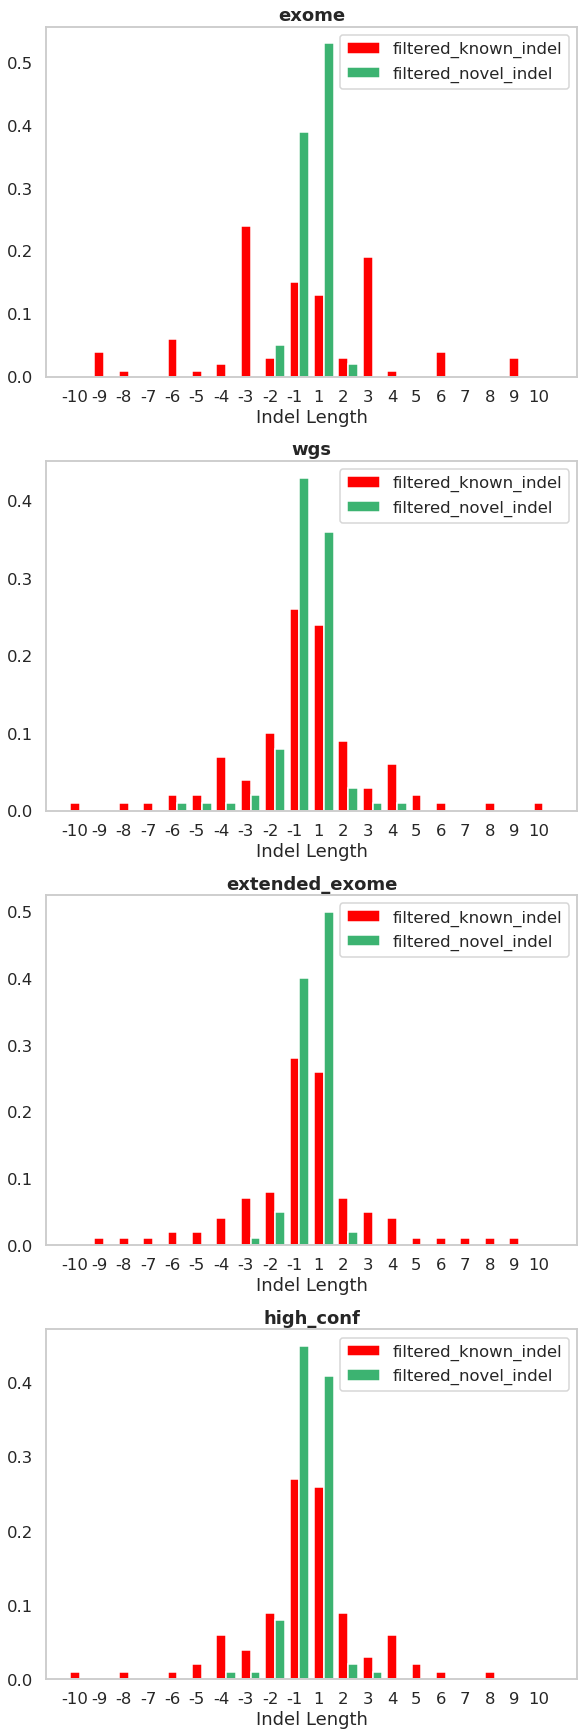

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
n = len(annotation_names)
sns.set_context("talk")
sns.set_style("whitegrid")
fig, ax = plt.subplots(n,1,figsize=(8,6*n), constrained_layout=True)
indelLengthHistogram = pd.read_hdf(h5_statistics,"/eval_IndelLengthHistogram")
for i,annotation_name in enumerate(annotation_names) :
    ins_del_hete_graph(indelLengthHistogram,ax[i],annotation_name,title=annotation_name)

## Allele Frequency

In [8]:
def allele_freq_graph(allele_freq_known,allele_freq_novel,ax, title=None):
    
    def read_allele_freq_df(allele_freq_path):
        with open(allele_freq_path,"r") as fi:
            table = []
            for ln in fi:
                if ln.startswith("AF"):
                    table.append(ln.split())

        df = pd.DataFrame(table)
        df.columns = ["AF","id","allele frequency","number of SNPs",
                         "number of transitions","number of transversions",
                         "number of indels","repeat-consistent","repeat-inconsistent","not applicable"]
        df = df.astype({"number of SNPs": 'float64', "allele frequency": 'float64'
                                   ,"number of indels": 'float64'})
        return df
    
    df_known = read_allele_freq_df(allele_freq_known)
    df_novel = read_allele_freq_df(allele_freq_novel)
    X = np.arange(20)
    ax.grid(False)
    ax.bar(df_known['allele frequency'] + 0.00, df_known["number of SNPs"], color = 'r', width = 0.01)
    ax.bar(df_novel['allele frequency'] + 0.01, df_novel["number of SNPs"], color = 'mediumseagreen', width = 0.01)
    ax.set_title(title,fontweight="bold")
    ax.legend(labels=['filtered_known', 'filtered_novel'])
    ax.set_xlabel('Allele Frequency')

In [9]:
def read_allele_freq_df(allele_freq_path):
    with open(allele_freq_path,"r") as fi:
        table = []
        for ln in fi:
            if ln.startswith("AF"):
                table.append(ln.split())

    df = pd.DataFrame(table)
    df.columns = ["AF","id","allele frequency","number of SNPs",
                     "number of transitions","number of transversions",
                     "number of indels","repeat-consistent","repeat-inconsistent","not applicable"]
    df = df.astype({"number of SNPs": 'float64', "allele frequency": 'object'
                               ,"number of indels": 'object'})
    return df

FileNotFoundError: [Errno 2] No such file or directory: 'allele_freq_known_snps.txt'

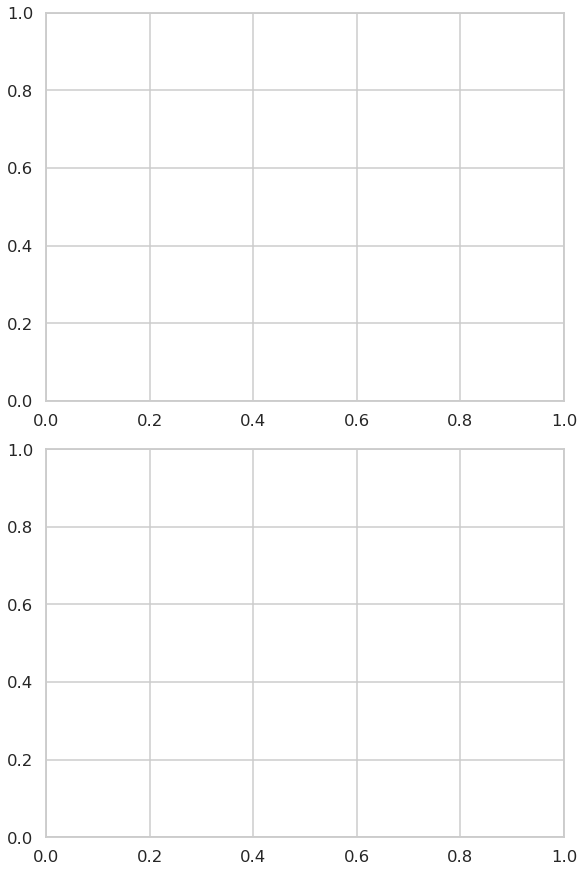

In [10]:
fig, ax = plt.subplots(2,1,figsize=(8,12), constrained_layout=True)
allele_freq_graph(allele_freq_known_snps,allele_freq_novel_snps,ax[0], title='Snps Allele Frequency')
allele_freq_graph(allele_freq_known_indels,allele_freq_novel_indels,ax[1], title='Indels Allele Frequency')